In [409]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import construction as cs
from ETN import count_ETN
from ETNgen import generate_seed_graphs,generate_graph_g2,get_dict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [410]:
def get_number_of_interactions(graphs):
    nb_inter = []
    for g in graphs:
        nb_inter.append(len(g.edges()))
    return nb_inter
    
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

from matplotlib.lines import Line2D

# load data as an array of static graphs

In [411]:
file_name = "InVS13"

data_in = cs.load_data("Datasets/"+file_name+".dat")

gap = 299 
# gap = 599 used  for SMS and calls
graphs = cs.build_graphs(data_in,gap=gap)

print(len(graphs))

3293


### decide local and global splitting

![title](img/Local_global_split.svg)

here you can set local and global split, so you can decide how many dictionary do you want in a global split

In [412]:
local_split = 3600*1 # 1 hours
global_slpit = 3600*24*7 # 1 day

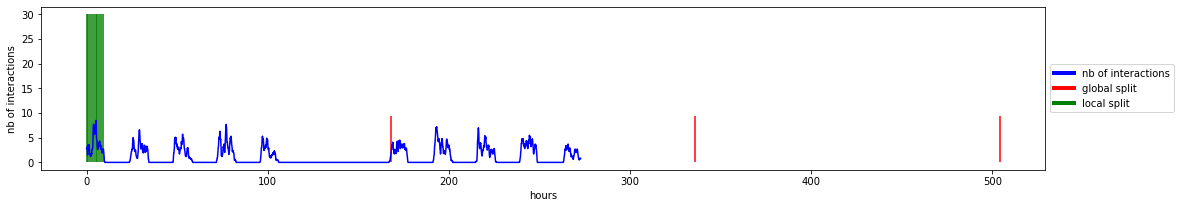

In [413]:
nb_inter = get_number_of_interactions(graphs)
smooth_nb_int = moving_average(nb_inter,10)
plt.figure(figsize=(18,3))
plt.plot(np.arange(0,len(smooth_nb_int)/(3600/gap),gap/3600), smooth_nb_int,color="blue")
plt.xlabel("hours")
plt.ylabel("nb of interactions")

plt.vlines(global_slpit/3600,0,np.max(smooth_nb_int)*1.1,color="red")
plt.vlines(global_slpit*2/3600,0,np.max(smooth_nb_int)*1.1,color="red")
plt.vlines(global_slpit*3/3600,0,np.max(smooth_nb_int)*1.1,color="red")
for i in range(10):
    plt.vlines(local_split*(i)/3600,0,30,color="green")


custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="green", lw=4)]
plt.legend(custom_lines, ['nb of interactions', 'global split', 'local split'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

### split graphs into list of graphs (depending on local splitting)

In [414]:
local_split = int(local_split/(gap+1))
global_slpit = int(global_slpit/(gap+1))

In [415]:
daily_graphs = []

for i in range(int(global_slpit/local_split)):
    daily_graphs.append([])
    
    
hour = 0
c = 1
for i in range(len(graphs)):
    g = graphs[i]
    if i < local_split*c:
        daily_graphs[hour].append(g)
    else:
        c = c + 1
        if hour == len(daily_graphs)-1:
            hour = 0
        else:
            hour = hour + 1
        daily_graphs[hour].append(g)

### count ETNS and store it in dictionaries (one for each local split)

In [416]:
k=2
ETNSs = []
dizs = []

for i in range(int(global_slpit/local_split)):
    ETNS = count_ETN(daily_graphs[i],k)
    ETNS = {k: v for k, v in sorted(ETNS.items(),reverse=True, key=lambda item: item[1])}
    
    ETNSs.append(ETNS)

    diz = get_dict(ETNS,k)
    dizs.append(diz)

### starting from a seed graph generate seed graphs up to k!

In [417]:
g0 = graphs[0]
graph_seed = generate_seed_graphs(g0,graphs,k,alpha = 0.5)

In [418]:
# decide how many graphs you want to generate
nb_graphs = len(graphs)

In [419]:
c =  1
hour = 0 
nodes = list(graph_seed[0].nodes())
tg = graph_seed
verbose = True

for i in range(nb_graphs-1):
    if i < local_split*c:
        pos = hour
    else:
        c = c + 1
        if hour == len(daily_graphs)-1:
            hour = 0
        else:
            hour = hour + 1
        pos = hour
        
    diz = dizs[pos]
        
    graphs_in = tg[i:i+k]
    g_new = generate_graph_g2(nodes,graphs_in,diz,k,alpha = 0.5)
    tg.append(g_new)
    
    
    if verbose:
        if i % 100 == 0:
            print(i,"over",nb_graphs)

0 over 3293
100 over 3293
200 over 3293
300 over 3293
400 over 3293
500 over 3293
600 over 3293
700 over 3293
800 over 3293
900 over 3293
1000 over 3293
1100 over 3293
1200 over 3293
1300 over 3293
1400 over 3293
1500 over 3293
1600 over 3293
1700 over 3293
1800 over 3293
1900 over 3293
2000 over 3293
2100 over 3293
2200 over 3293
2300 over 3293
2400 over 3293
2500 over 3293
2600 over 3293
2700 over 3293
2800 over 3293
2900 over 3293
3000 over 3293
3100 over 3293
3200 over 3293


# save graphs as temporal edge list

In [420]:
new_temporal_graph_name = "ETNgen-"+file_name
print(new_temporal_graph_name)

ETNgen-InVS13


In [421]:
edge_list = []
c = 0 
gap = 300
nodes = set()
for i in tg:
    edges = list(i.edges())

    for a,b in edges:
        edge_list.append([c*gap,a,b])
        nodes.add(a)
        nodes.add(b)
    c = c + 1
    
orig_nod = set(tg[0].nodes())
diff = orig_nod.difference(nodes)
for i in diff:
    edge_list.append([c*gap,i,i])

In [422]:
df_edge_list = pd.DataFrame(edge_list,columns=["time","node_A","node_B"])
df_edge_list.to_csv("Generated_graphs/"+new_temporal_graph_name+".dat",sep=" ",index=False,header=False)

# plot

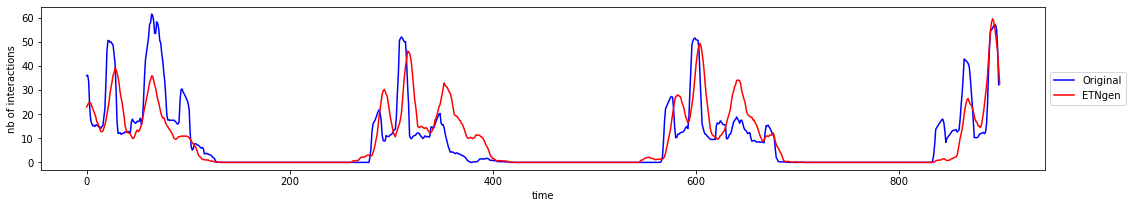

In [249]:
w = 10
nb_inter = get_number_of_interactions(graphs)
smooth_nb_int = moving_average(nb_inter,w)


plt.figure(figsize=(18,3))
plt.plot(smooth_nb_int,color="blue",label="Original")
plt.plot(moving_average(get_number_of_interactions(tg),w),color="red",label="ETNgen")
plt.xlabel("time")
plt.ylabel("nb of interactions")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()